# Multi-Channel CNN with 2 branches

This code combines raster images and location-specific variables to predict the target groundwater recharge rate in Australia.
It takes as input raster images in the folder "aux_inputs" and location specific features from the files in the folder "Data and with names "train_data.csv", "val_data.csv" and "test_data.csv". The variable names of the features are specified in the code and can be altered.

In [40]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import sys
sys.path.append('..')va
#from Workflow import Workflow
from glob import glob


# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)


## Data pre-processing

### Reading the location input data

In [41]:
def load_data(path, trainparams, y_var, seed=42):
    """
    Loads data from the specified path and splits it into training, validation, and test sets.
    
    Parameters:
    path (str): The directory path where the data files are located.
    trainparams (list): List of training parameters (features).
    y_var (str): The target variable for training.
    seed (int): Random seed for reproducibility. Default is 42.
    
    Returns:
    tuple: A tuple containing the training features, training target, validation features, 
           validation target, test features, and test target.
    """
    #df = pd.read_csv(os.path.join(path, "dat07_u.csv"), low_memory=False).sample(frac=1, random_state=seed)

    train_data = pd.read_csv(os.path.join(path, 'train_data.csv'))
    Xtrain = train_data[trainparams]
    ytrain = train_data[y_var]

    validation_data = pd.read_csv(os.path.join(path, 'validation_data.csv'))
    Xvalid = validation_data[trainparams]
    yvalid = validation_data[y_var]

    test_data = pd.read_csv(os.path.join(path, 'test_data.csv'))
    Xtest = test_data[trainparams]
    ytest = test_data[y_var]

    return Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest

#DataLocation = os.path.join('..', 'data')
#os.chdir(DataLocation)
loc_features = ['lat','lon','Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']
target_var = "Recharge RC 50% mm/y"

X_train_loc, y_train, X_val_loc, y_val, X_test_loc, y_test = load_data('../data/', loc_features, target_var)


In [42]:
# load the training,validation and test dataset from the workflow
#wf = Workflow()
#X_train_loc,y_train, X_val_loc, y_val, X_test_loc, y_test = wf.load_data()

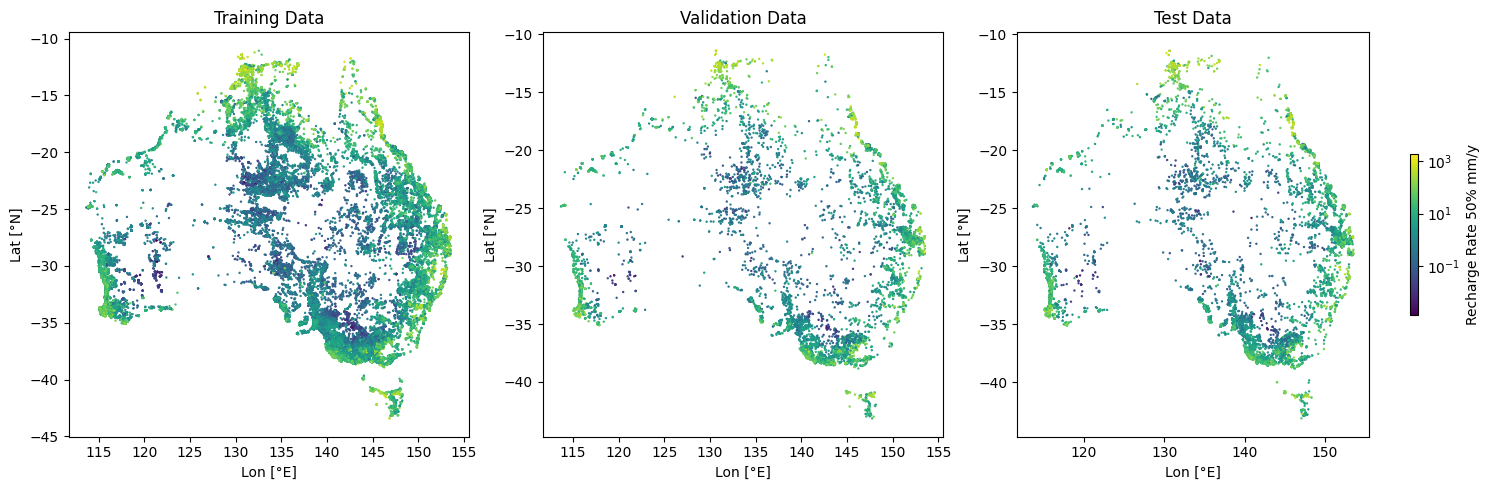

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Determine the common color range for all scatter plots
vmin = min(y_train.min(), y_val.min(), y_test.min())
vmax = max(y_train.max(), y_val.max(), y_test.max())

# Training Data
axs[0].scatter(X_train_loc.lon, X_train_loc.lat, c=y_train, s=0.5, cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
axs[0].set_title('Training Data')
axs[0].set_xlabel('Lon [°E]')
axs[0].set_ylabel('Lat [°N]')

# Validation Data
axs[1].scatter(X_val_loc.lon, X_val_loc.lat, c=y_val, s=0.5, cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
axs[1].set_title('Validation Data')
axs[1].set_xlabel('Lon [°E]')
axs[1].set_ylabel('Lat [°N]')

# Test Data
sc = axs[2].scatter(X_test_loc.lon, X_test_loc.lat, c=y_test, s=0.5, cmap='viridis', norm=LogNorm(vmin=vmin, vmax=vmax))
axs[2].set_title('Test Data')
axs[2].set_xlabel('Lon [°E]')
axs[2].set_ylabel('Lat [°N]')

# Add a colorbar only for the Test Data plot
cbar = fig.colorbar(sc, ax=axs[2], orientation='vertical', fraction=0.02, pad=0.1)
cbar.set_label('Recharge Rate 50% mm/y')

plt.tight_layout()


### Loading the bore-hole centered raster images

In [43]:

#train
geometry_train = [Point(xy) for xy in zip(X_train_loc['lon'], X_train_loc['lat'])]
Xtrain_gdf = gpd.GeoDataFrame(X_train_loc, geometry=geometry_train, crs="EPSG:3577")  # WGS84 (lat/lon)

Xtrain_gdf['x'] = Xtrain_gdf.geometry.x
Xtrain_gdf['y'] = Xtrain_gdf.geometry.y

#validation
geometry_val = [Point(xy) for xy in zip(X_val_loc['lon'], X_val_loc['lat'])]
Xval_gdf = gpd.GeoDataFrame(X_val_loc, geometry=geometry_val, crs="EPSG:3577")  # WGS84 (lat/lon)

Xval_gdf['x'] = Xval_gdf.geometry.x
Xval_gdf['y'] = Xval_gdf.geometry.y

#test
geometry_test = [Point(xy) for xy in zip(X_test_loc['lon'], X_test_loc['lat'])]
Xtest_gdf = gpd.GeoDataFrame(X_test_loc, geometry=geometry_test, crs="EPSG:3577")  # WGS84 (lat/lon)

Xtest_gdf['x'] = Xtest_gdf.geometry.x
Xtest_gdf['y'] = Xtest_gdf.geometry.y

In [44]:
# 1. Load Raster Images
def load_data(filepath):
    with rasterio.open(filepath) as src:
        values = src.read(1)  # Load the first band
        transform = src.transform
    return values, transform

#Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, values, transform, size=32):
    rows, cols = values.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)

        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = values[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

#the images that are going to be used are in this directory
directory_path = r"./aux_inputs"
# List all .tif files in the directory
tif_files = glob(os.path.join(directory_path, "*.tif"))

#empty list to store image values
columns_list = []

def centered_img(data):
    #routine for looping through all files and extracting centered images
    for file_path in tif_files:
        print(f"Processing file: {file_path}")

        # Load the data
        values, transform = load_data(file_path)

        # Extract the centered images
        imgs_ann = extract_sample_centered_images(data, values, transform)

        # Append the result to the list
        columns_list.append(imgs_ann)
    all_imgs_ann = list(zip(*columns_list))
    columns_list.clear()
    return np.array(all_imgs_ann)


In [45]:
# Use the updated coordinates
x_train_imgs = centered_img(Xtrain_gdf)
x_val_imgs = centered_img(Xval_gdf)
x_test_imgs = centered_img(Xtest_gdf)

Processing file: ./aux_inputs\rainfall_raster_bound.tif
Processing file: ./aux_inputs\rainfall_raster_bound.tif
Processing file: ./aux_inputs\rainfall_raster_bound.tif


#### Checking the centered images

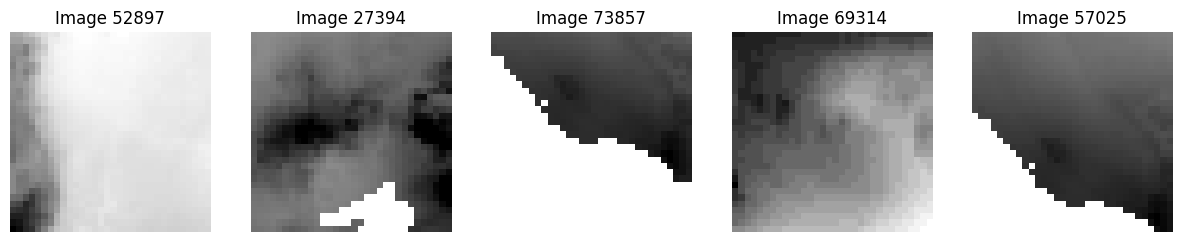

In [46]:
#how many centered images to show
n = 5

# Select random images or specific indices
indices = np.random.choice(len(x_train_imgs), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(x_train_imgs[idx][0], cmap="binary")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Normalizing the data

In [47]:
#Normalization for location inputs (dense branch)
class MinMaxScaler:
    def __init__(self, train_data):
        # Calculate min and max from training data
        self.min = train_data.min(axis=0)
        self.max = train_data.max(axis=0)

    def normalize(self, data):
        # Normalize data using the min and max from the training data
        return (data - self.min) / (self.max - self.min)

# Create a normalizer using the training data
normalizer = MinMaxScaler(X_train_loc)

# Normalize the validation and test data using the same normalizer
x_train_loc_norm = normalizer.normalize(X_train_loc)
x_val_loc_norm = normalizer.normalize(X_val_loc)
x_test_loc_norm = normalizer.normalize(X_test_loc)

In [48]:
# Normalization for convolutionary branch inputs

class MinMaxScaler_imgs:
    def __init__(self, train_data):
        data = train_data.reshape(-1, train_data.shape[1])
        # Calculate min and max from training data across each channel
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)

    def normalize(self, data):
        data_reshaped = data.reshape(-1, data.shape[1])
        # Added a small epsilon to avoid division by zero
        
        epsilon = 1e-10
        normalized_data = (data_reshaped - self.min) / (self.max - self.min + epsilon)
        # Reshape back to original shape
        return normalized_data.reshape(data.shape)

normalizer_imgs = MinMaxScaler_imgs(x_train_imgs)

x_train_imgs_norm = normalizer_imgs.normalize(x_train_imgs)
x_val_imgs_norm = normalizer_imgs.normalize(x_val_imgs)
x_test_imgs_norm = normalizer_imgs.normalize(x_test_imgs)

## Model Definition

In [12]:
# Use neural network to learn relationship between terrain features and geochemistry ####
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros
#from tensorflow_probability import distributions as tfd
#import tensorflow_probability as tfp

In [13]:
num_channels = x_train_imgs_norm.shape[1]
num_features = X_train_loc.shape[1]
imagedim = x_train_imgs.shape[2]

In [14]:
x_train = [np.transpose(x_train_imgs_norm, (0, 2, 3, 1)), x_train_loc_norm]
x_val = [np.transpose(x_val_imgs_norm, (0, 2, 3, 1)), x_val_loc_norm]
x_test = [np.transpose(x_test_imgs_norm, (0, 2, 3, 1)), x_test_loc_norm]


In [15]:

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5 
dropratedense = 0.2 

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(imagedim, imagedim, num_channels), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(num_features,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)

main_output = Dense(units=1, activation="linear", name="output")(main_output) #singe value in the output

#main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
#main_output = tf.keras.layers.Lambda(          #multiple output values
#    lambda x: tf.concat([x[:, 0:1], tf.math.softplus(x[:, 1:2])], axis=1)
#)(main_output)

# Define model inputs
model = tf.keras.Model(
    inputs=[conv_input, auxiliary_input],
    outputs=main_output
)

# Define the negative log-likelihood function
#def negloglik(y_true, y_pred):
#    # Assuming y_pred is a distribution, e.g., Normal distribution
#    dist = tfd.Normal(loc=y_pred[:, 0], scale=tf.math.softplus(y_pred[:, 1]))
#    return -tf.reduce_mean(dist.log_prob(y_true))


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay=1e-6), 
              loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ conv_input          │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 10, 10,    │      1,280 │ conv_input[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10, 10,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 10, 10,    │          0 │ activation[0][0]  │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 8, 8, 128) │          0 │ conv2d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 8, 8, 128) │          0 │ activation_1[0][… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 6, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 6, 6, 128) │          0 │ conv2d_2[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_2 │ (None, 6, 6, 128) │          0 │ activation_2[0][… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 128) │    147,584 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_input           │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 4, 4, 128) │          0 │ conv2d_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1920)      │     21,120 │ aux_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_3 │ (None, 4, 4, 128) │          0 │ activation_3[0][… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 1920)      │          0 │ dense[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ spatial_dropout2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1920)      │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,825,985 (10.78 MB)

 Trainable params: 2,825,985 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [17]:
#class for saving the best weights
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

save_best_model = SaveBestModel()

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 10
epochs = 30

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2,
    callbacks=[save_best_model]
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)


Epoch 1/30
7886/7886 - 488s - 62ms/step - loss: 4204.0718 - val_loss: 4086.6541
Epoch 2/30


KeyboardInterrupt: 

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# loading weights of best epoch
model.set_weights(save_best_model.best_weights)
# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': model.predict(x_test)[:, 0]})

from sklearn.metrics import r2_score

# Calculate and print R squared and RMSE
print(f"R squared = {round(r2_score(holdout['obs'], holdout['preds']), 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")

In [ ]:
# Assuming 'model' is your trained Keras model
model.save_weights('models/model_rain_all_400.weights.h5')

## Making predictions for Australia

In [51]:
australia = pd.read_csv(os.path.join('../data/', 'Australia_grid_0p05_data_with_rain.csv'))
x_aus_loc = australia[loc_features]

x_aus_loc_norm = normalizer.normalize(x_aus_loc)

#train
geometry_aus = [Point(xy) for xy in zip(x_aus_loc['lon'], x_aus_loc['lat'])]
x_aus_gdf = gpd.GeoDataFrame(x_aus_loc, geometry=geometry_aus, crs="EPSG:3577")  # WGS84 (lat/lon)

x_aus_gdf['x'] = x_aus_gdf.geometry.x
x_aus_gdf['y'] = x_aus_gdf.geometry.y

In [52]:
x_aus_imgs = centered_img(x_aus_gdf)
x_aus_imgs_norm = normalizer_imgs.normalize(x_aus_imgs)

Processing file: ./aux_inputs\rainfall_raster_bound.tif


In [53]:
x_aus = [np.transpose(x_aus_imgs_norm, (0, 2, 3, 1)), x_aus_loc_norm]

In [54]:
model.load_weights('models/model_rain_all_500_train_data.weights.h5')
predictions_australia = model.predict(x_aus)


8637/8637 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step


<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\nefel\AppData\Local\Temp\ipykernel_14776\1333360138.py:14: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('Longitude ($\degree$E)')
C:\Users\nefel\AppData\Local\Temp\ipykernel_14776\1333360138.py:15: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel('Latitude ($\degree$N)')


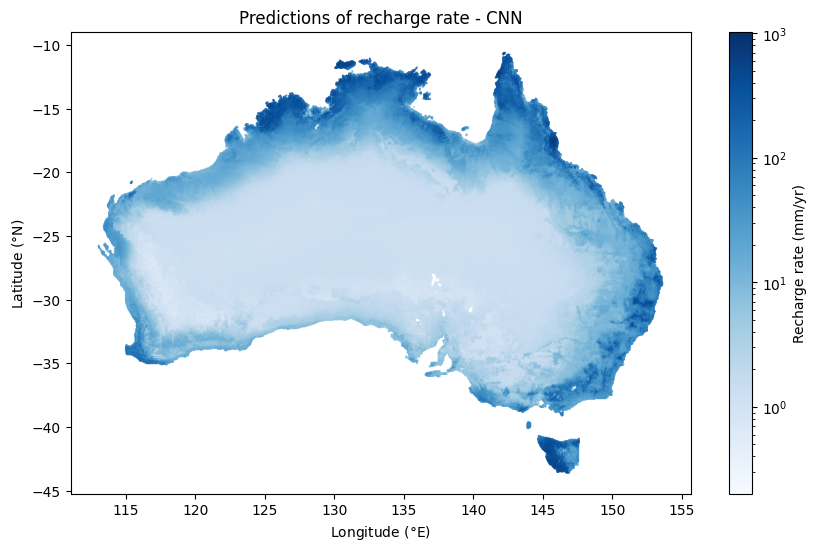

In [107]:
import matplotlib.pyplot as plt

# Extract latitude and longitude
latitudes = x_aus_loc['lat']
longitudes = x_aus_loc['lon']

# Flatten the predictions to match the lat/lon pairs
predictions_flat = predictions_australia.flatten()

# Create the plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(longitudes, latitudes, s=0.1, c=predictions_flat, cmap='Blues' , norm=LogNorm())
plt.colorbar(sc, label='Recharge rate (mm/yr)')
plt.xlabel('Longitude ($\degree$E)')
plt.ylabel('Latitude ($\degree$N)')
plt.title('Predictions of recharge rate - CNN')
plt.show()

In [57]:
# Create a DataFrame with the required columns
predictions_df = pd.DataFrame({
    'lat': latitudes,
    'lon': longitudes,
    'predicted RC 50% mm/y': predictions_flat
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('../Data/predictions_CNN.csv', index=False)


In [58]:
holdout = pd.DataFrame({'obs': y_test, 'preds': model.predict(x_test)[:, 0]})

from sklearn.metrics import r2_score

# Calculate and print R squared and RMSE
print(f"R squared = {round(r2_score(holdout['obs'], holdout['preds']), 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")

309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
R squared = 0.729
RMSE = 52.763


Text(0.95, 0.05, 'R² = 0.729\nRMSE = 52.763')

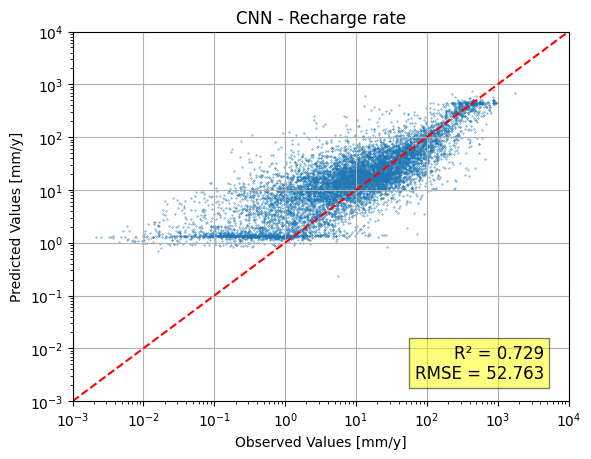

In [105]:
plt.scatter(holdout['obs'], holdout['preds'], s=0.1)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('CNN - Recharge rate')

# Plot the line with the same limits
plt.plot([1e-3, 1e4], [1e-3, 1e4], color='red', linestyle='--')

# Set the same limits for both axes
plt.xlim(1e-3, 1e4)
plt.ylim(1e-3, 1e4)

plt.xlabel('Observed Values [mm/y]')
plt.ylabel('Predicted Values [mm/y]')
plt.text(0.95, 0.05, f'R² = {round(r2_score(holdout["obs"], holdout["preds"]), 3)}\nRMSE = {round(np.sqrt(np.mean((holdout["preds"] - holdout["obs"])**2)), 3)}', 
         fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes,
         bbox=dict(facecolor='yellow', alpha=0.5))